### This notebook takes you through the first few steps of using HUXt. A link to the main example notebook is here: https://github.com/University-of-Reading-Space-Science/HUXt/blob/master/code/HUXt_examples.ipynb. 

### Task one: review this notebook, try running parts of it by copy pasting into this new notebook. 

-Identify where you create an input for the boundary condition. 

-Identify where you run the model. 

-Identify where you view the timeseries/radial profile. 

-Identify where you can view the 2D model output.  

-Identify where you can inject a CME. 

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import datetime
import os
import sys
sys.path.insert(0,"../HUXt/code")
sys.path.append('./orbitals_download/')
import importlib
import helpers as hp
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
import sunpy
from sunpy.coordinates import sun
import httplib2
from scipy.interpolate import interp1d
from pandas import Series
from astropy.time import Time
import pickle


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2
})
    

/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already exist for CR2295


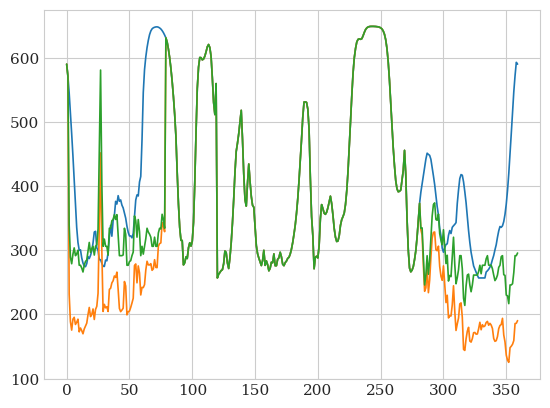

In [3]:
v_mas = Hin.get_MAS_long_profile(cr=2295)
v_merged = hp.get_v_merged(21,v_mas)
v_merged_accel = hp.get_v_merged_accel(21,v_mas)
plt.plot(v_mas)
plt.plot(v_merged)
plt.plot(v_merged_accel)

In [31]:
# print(v_merged_accel.shape, type(v_merged_accel), v_merged_accel.unit)

In [7]:
def run_huxt_for_encounter(enc):
    # --- load encounter data 
    df = hp.get_prograde_df(enc)
    df_full = pd.read_csv(f"../data/E{enc:02d}.csv")

    
    # --- carrington  
    cr, cr_start = hp.carrington_info(df['time'].iloc[0])
    df['Time_days'] = hp.days_since(df['time'], cr_start)
    df_full['Time_days'] = hp.days_since(df_full['Times'], cr_start)

    # --- load boundary conditions 
    v_mas             = Hin.get_MAS_long_profile(cr, 0.0*u.deg)     
    v_merged          = hp.get_v_merged(enc, v_mas)                  
    v_merged_accel    = hp.get_v_merged_accel(enc,v_mas)              

    # --- run HUXt simulations
    simtime    = 2 * 27.2753 * u.day
    m_acc      = H.HUXt(v_boundary=v_merged_accel, cr_num=cr, simtime=simtime, dt_scale=4, r_min=30 * u.solRad)
    m_na       = H.HUXt(v_boundary=v_merged, cr_num=cr, simtime=simtime, dt_scale=4, r_min=30 * u.solRad)
    m_mas      = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=simtime, dt_scale=4, r_min=30 * u.solRad)
    for m in (m_acc, m_na, m_mas):
        m.solve([])

    # --- interpolate L1 data 
    t_vec      = np.linspace(0, simtime.to_value(u.day), len(v_mas))
    v_L1       = interp1d(df_full['Time_days'], df_full['Vpr-L1'], bounds_error=False, fill_value='extrapolate')(t_vec)

    # --- rMSE calculations 
    mask       = np.ones_like(v_L1, dtype=bool)         
    r_acc      = hp.rmse(v_merged_accel.value,  v_L1, mask)
    r_na       = hp.rmse(v_merged.value, v_L1, mask)
    r_mas      = hp.rmse(v_mas.value,    v_L1, mask)


    lon_grid   = np.arange(0, 360) 
    lon_min    = df['longitude'].min()         
    lon_max    = df['longitude'].max()           
    psp_mask   = (lon_grid >= lon_min) & (lon_grid <= lon_max)
    v_merged_accel_plot = np.where(psp_mask, v_merged_accel.value, np.nan) * v_merged_accel.unit
    fig_bc, ax = plt.subplots(figsize=(7, 5))
    ax.plot(lon_grid, v_mas,     label='Vmas',    color='orange')
    ax.plot(lon_grid, v_merged,  label='Vmerged', color='black')
    ax.plot(lon_grid, v_merged_accel_plot,              # masked version!
             label='Vaccel',  color='maroon', ls='-', lw=1)
    ax.axvspan(lon_min, lon_max, color='gray', alpha=0.1)
    ax.set_ylabel(r"Radial Velocity (km s$^{-1}$)")
    ax.set_title(f"Boundary conditions (ENC {enc})")
    ax.legend(frameon=False)
    ax.grid(alpha=.3)
    fig_bc.tight_layout()
    plt.show()


    # --- plot time series at L1 ---
    fig_ts, ax = HA.plot_timeseries(m_acc, 1 * u.au, 0 * u.deg)
    ax.lines[0].set_color('maroon')
    ax.lines[0].set_label(f'Vaccel (RMSE={r_acc:.0f})')

    for m, color, label, rmse in [(m_na, 'orange', 'Vmerged', r_na), (m_mas, 'k', 'Vmas', r_mas)]:
        ff, aa = HA.plot_timeseries(m, 1 * u.au, 0 * u.deg)
        ax.plot(aa.lines[0].get_xdata(), aa.lines[0].get_ydata(),
                color=color, label=f'{label} (RMSE={rmse:.0f})')

    ax.plot(df_full['Time_days'], df_full['Vpr-L1'], color='b', label='L1 obs')
    ax.set(xlabel='Time (days since CR start)', ylabel='Speed (km/s)',
           title=f'HUXt vs L1 – Encounter {enc}')
    ax.set_xlim(0, simtime.to_value(u.day))
    ax.legend()
    ax.grid()
    fig_ts.tight_layout()
    plt.show()

    return dict(rmse_accel=r_acc, rmse_noaccel=r_na, rmse_mas=r_mas)



--- Encounter 21 ---
Files already exist for CR2289


/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


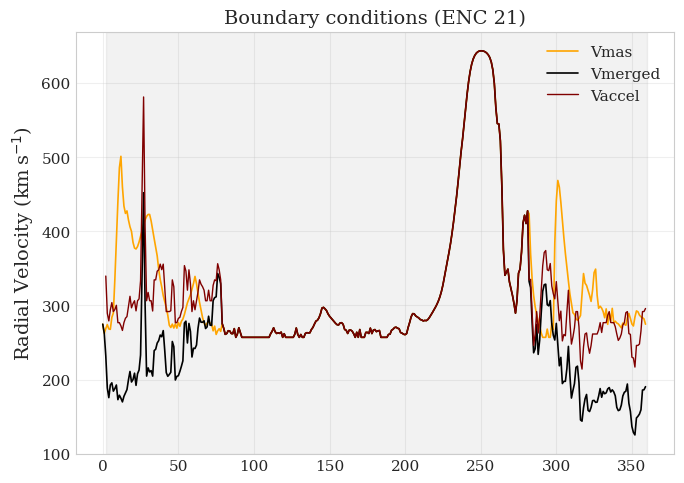

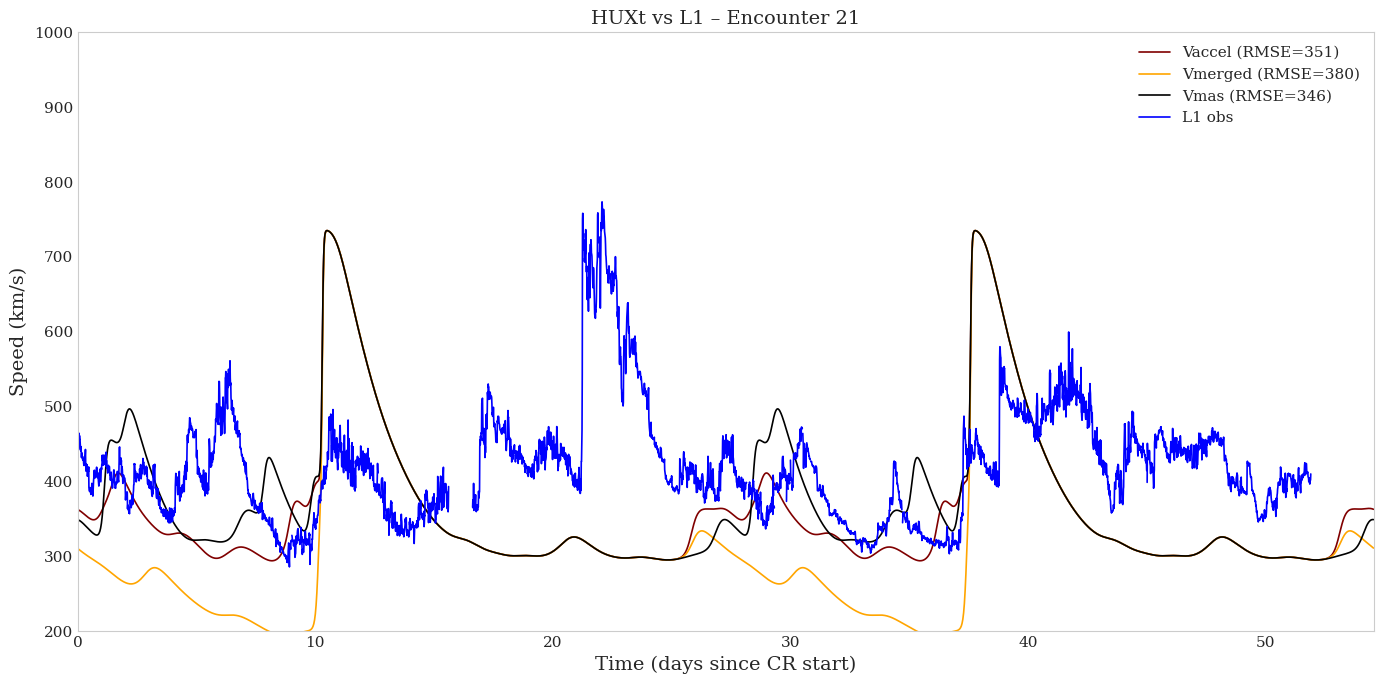

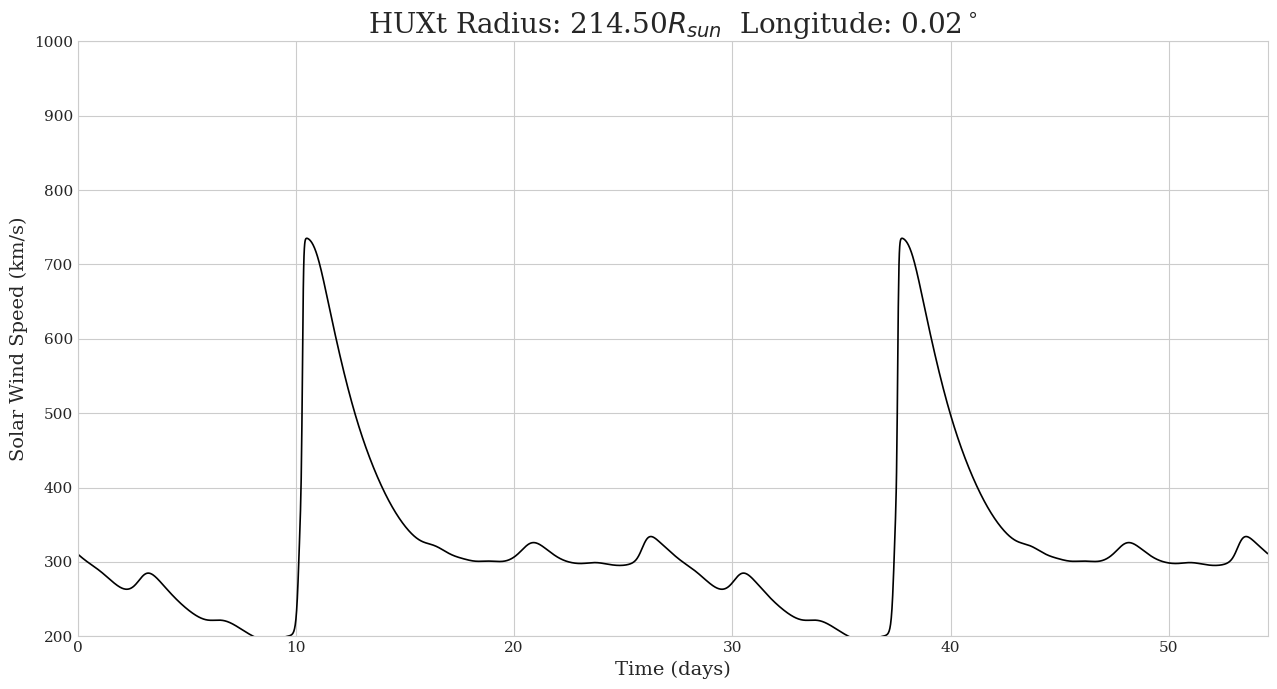

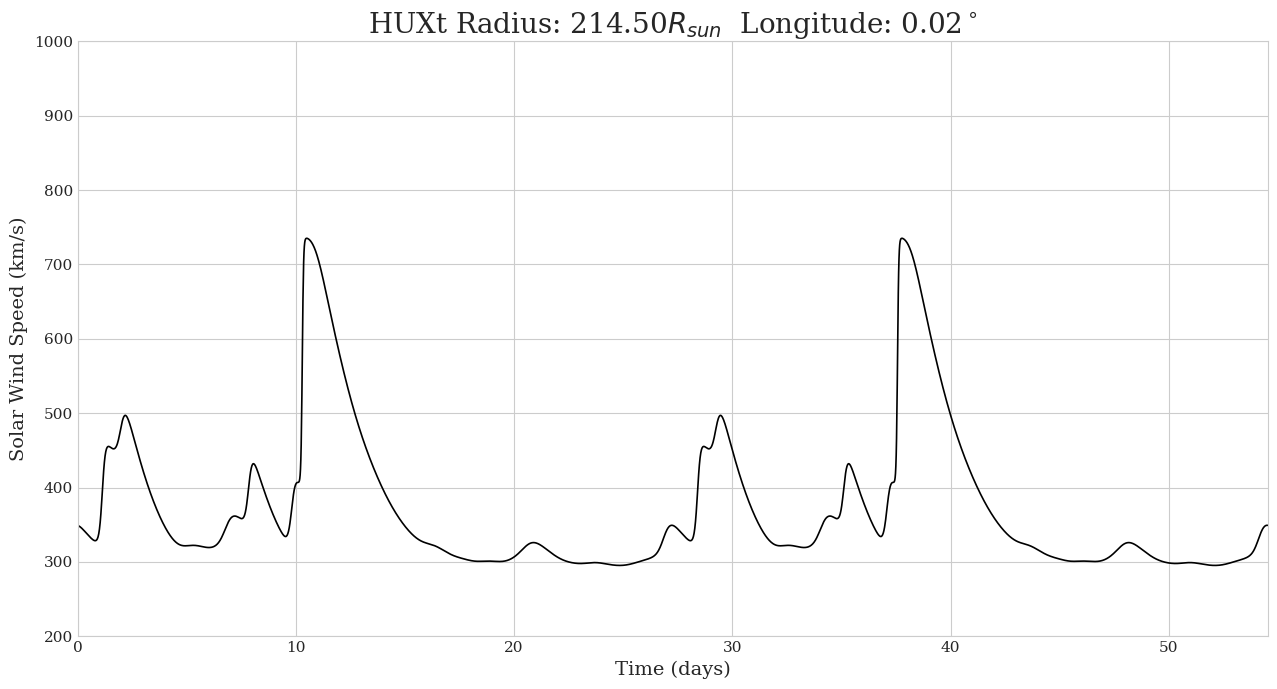


--- Encounter 22 ---
Files already exist for CR2292


/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


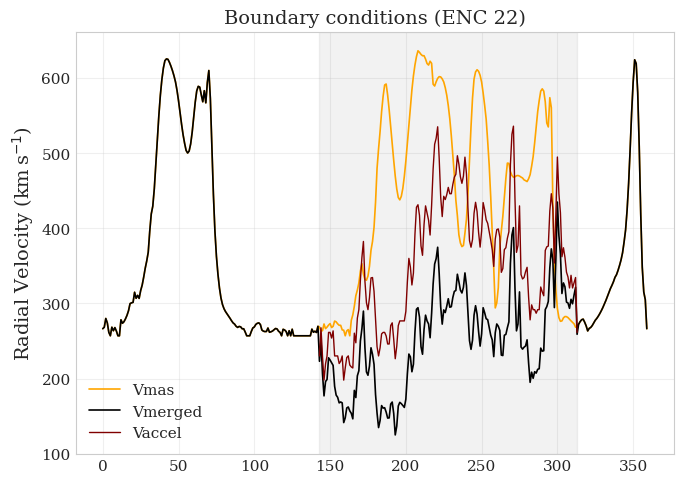

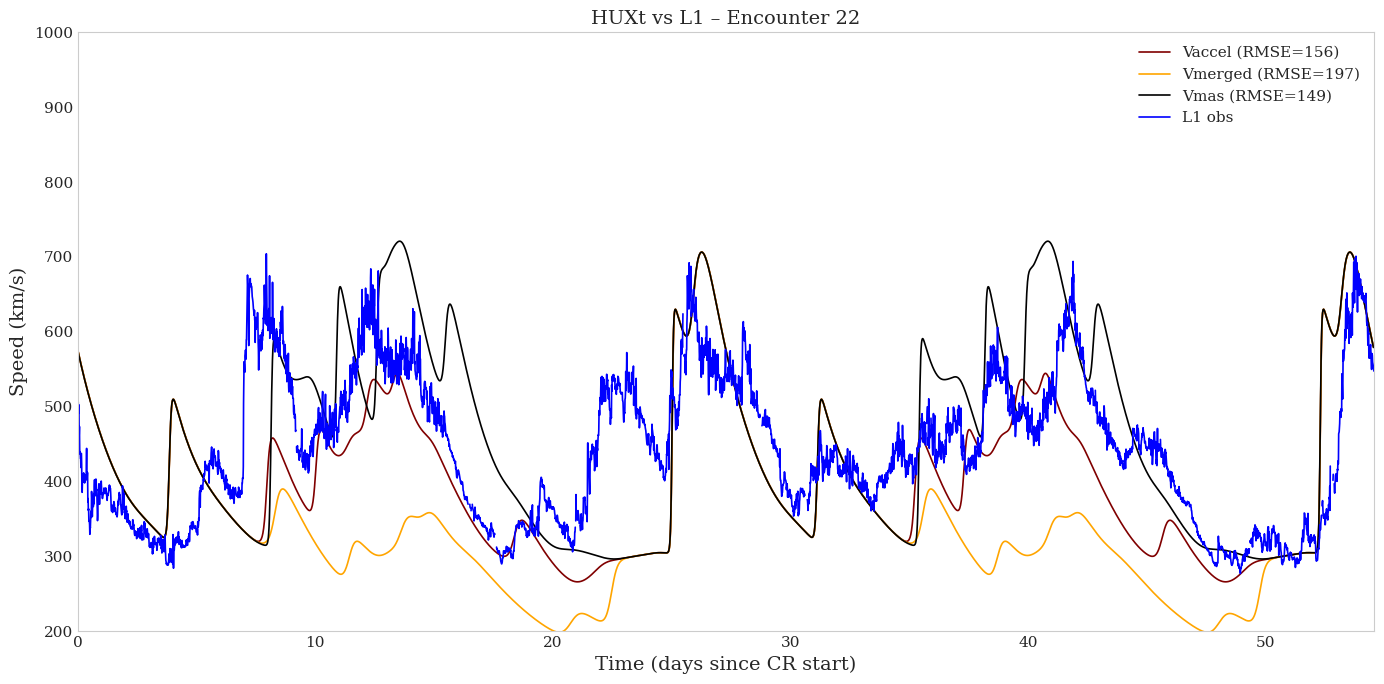

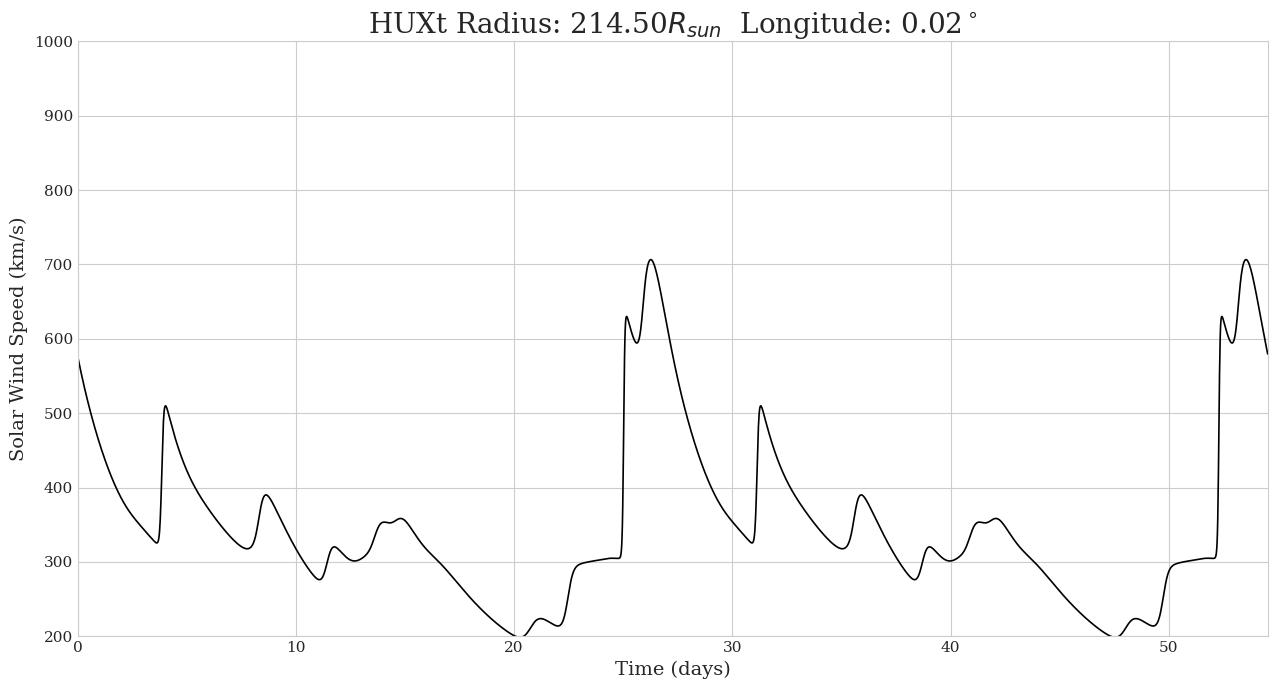

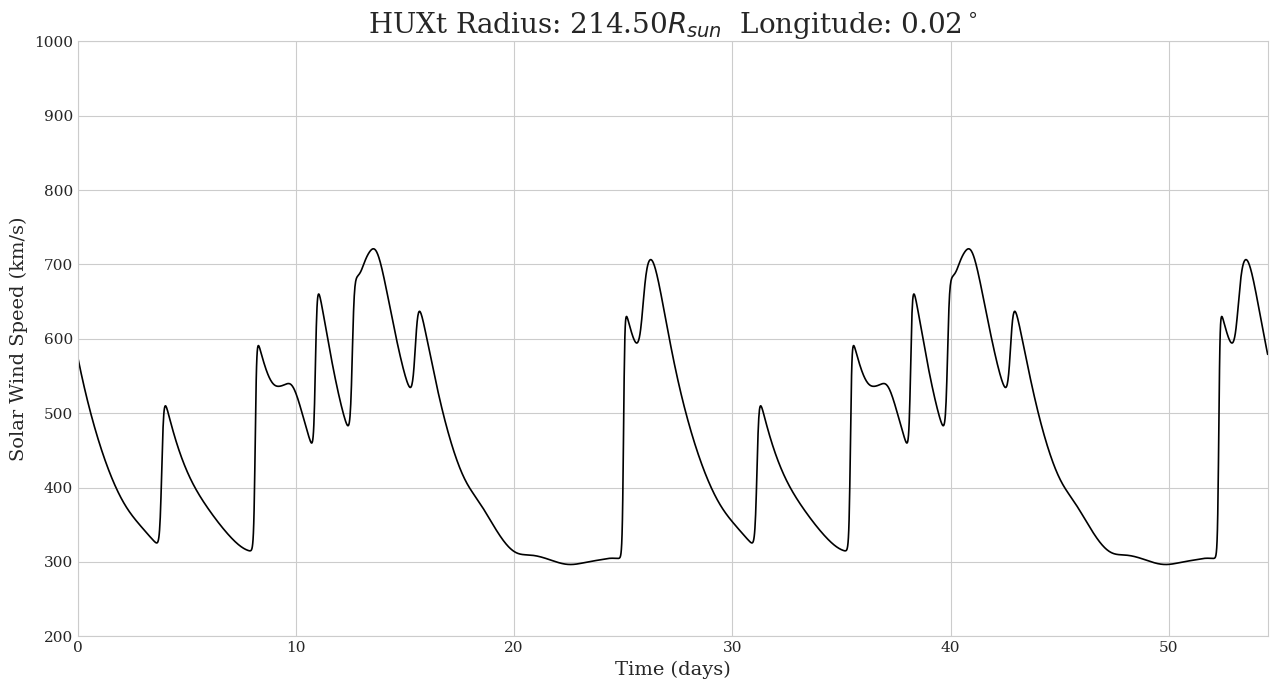


--- Encounter 23 ---
Files already exist for CR2295


/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


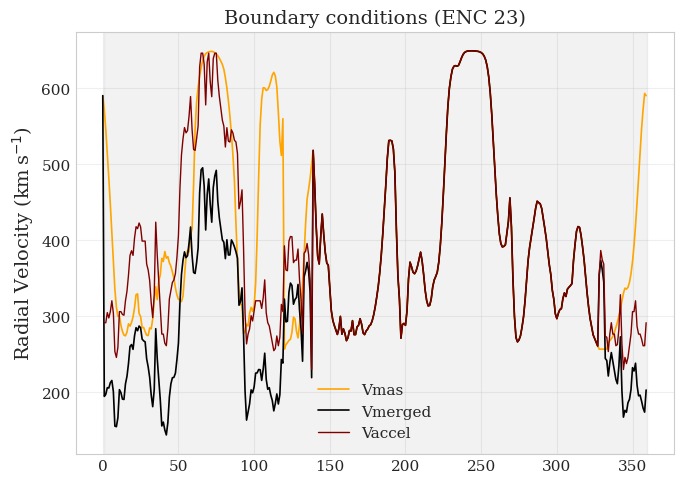

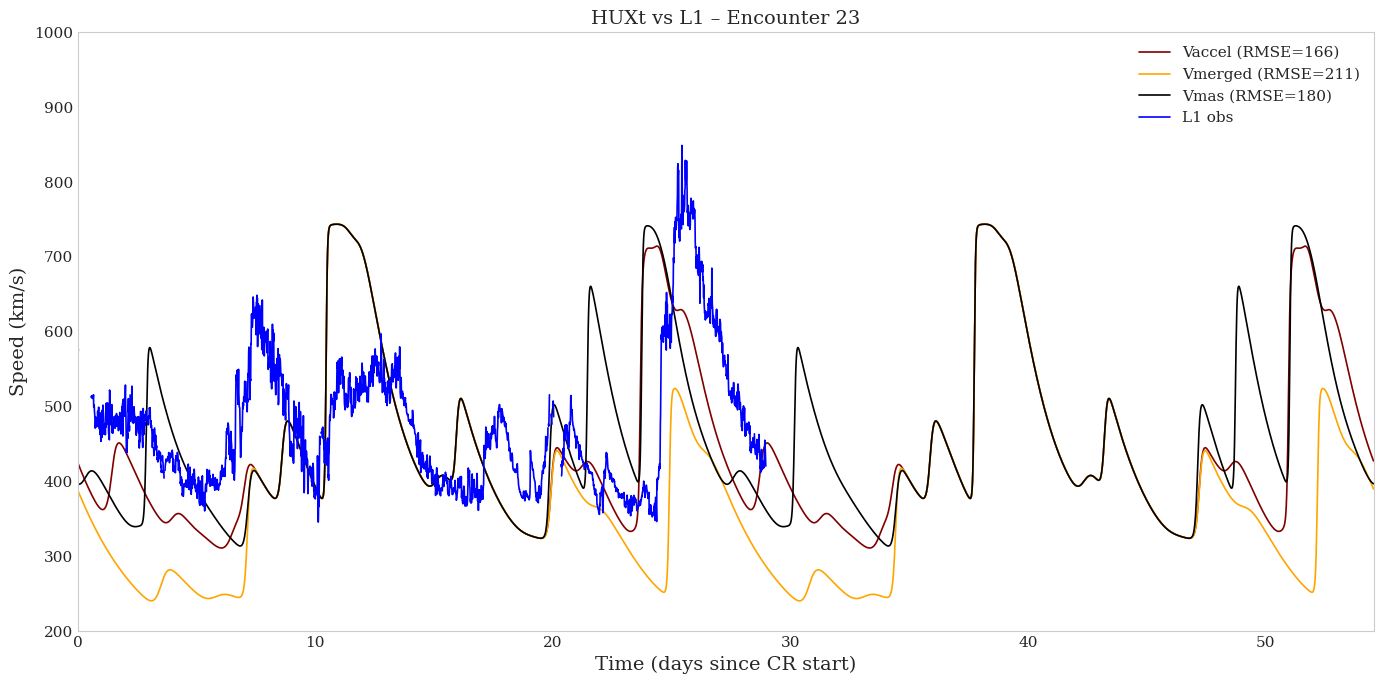

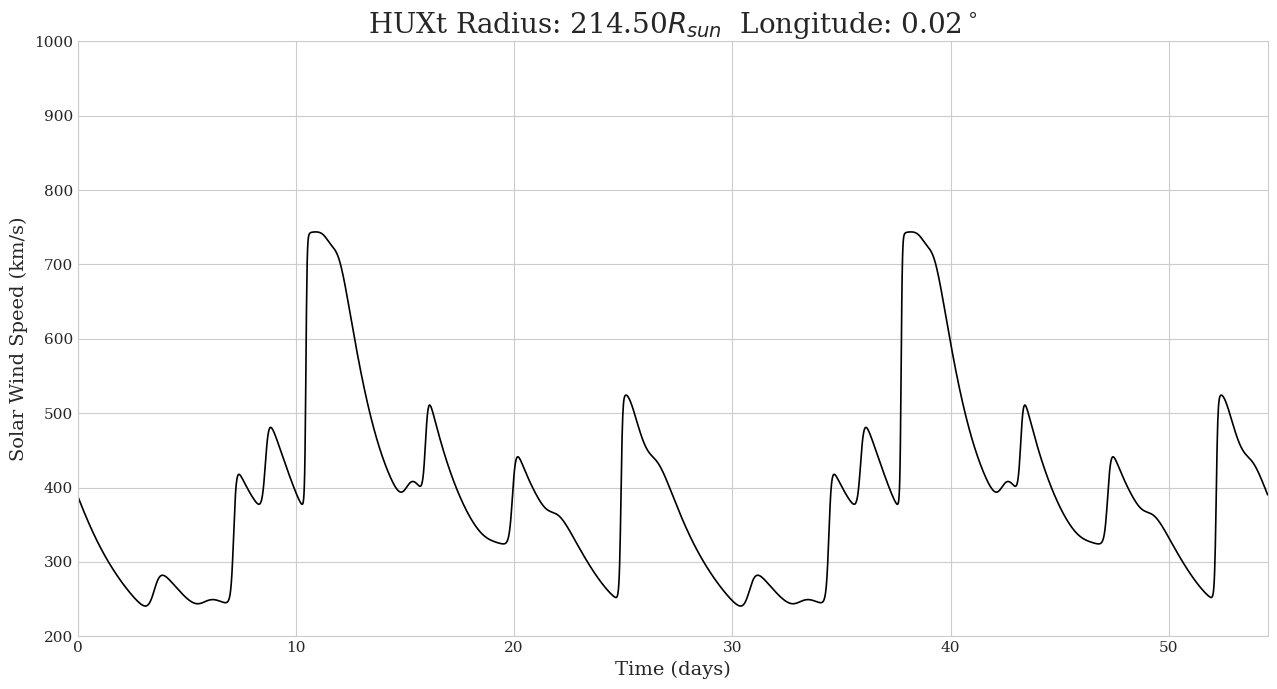

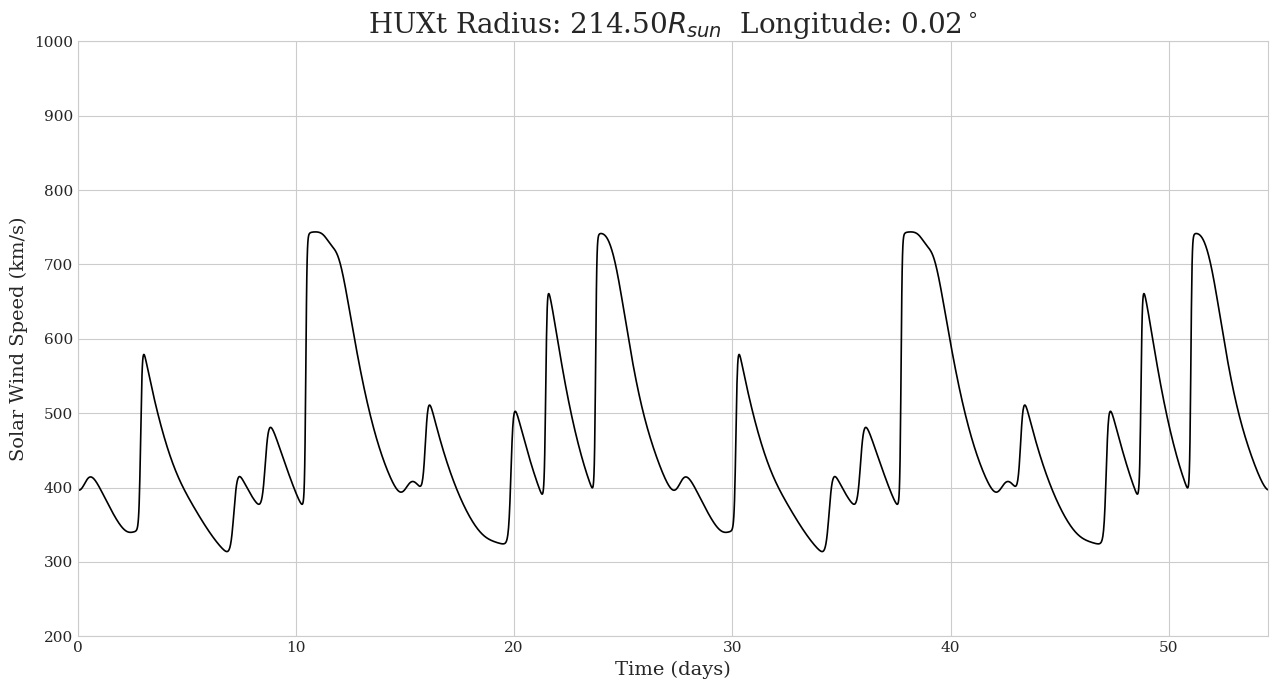

In [10]:
# show every encounter, nothing gets written to disk
for enc in range(21, 24):          # 1 … 23
    print(f"\n--- Encounter {enc} ---")
    _ = run_huxt_for_encounter(enc)   # ← no files

In [24]:
# models = pickle.load(open('../data/the_models_2025-05-01','rb'))
# model_distance = models[0][0].to_value(u.solRad)  # array of radii in R☉
# model_velocity_set = np.array([v.to_value(u.km/u.s) for v in models[0][2]])  # list of velocity profiles in km/s

# df = helpers.get_prograde_df(22)

# # r_target = 30  # target radius in R☉
# # boost_factor = 1.3
# # threshold = 100  # km/s


# adjusted_vr = []

# # Loop through each PSP point and apply selective boost
# for i in range(len(df)):
#     v0 = df.iloc[i]['Vr']
#     r0 = df.iloc[i]['radius']

#     r_index = np.argmin(np.abs(model_distance - r0))
#     v_column = model_velocity_set[:,r_index]

#     v_index = np.argmin(np.abs(v_column - v0))
#     v_profile = model_velocity_set[v_index,:]

#     r_30 = np.argmin(np.abs(model_distance - 30))
#     adjusted_vr_at_30 = v_profile[r_30]

#     plt.scatter(r0,v0)
#     plt.scatter(30,adjusted_vr_at_30)
#     plt.axvline(x=30, color='black', linestyle='--')

    
#     # # Boost if above threshold, leave as-is if not
#     # if v0 > threshold:
#     #     v_at_30 = v0 * boost_factor
#     # else:
#     #     v_at_30 = v0

#     # Create a flat profile across the radius grid with that boosted value

#     adjusted_vr.append(adjusted_vr_at_30)

# for velocity in model_velocity_set:
#     plt.plot(model_distance, velocity, linewidth=1)

# # # Extract adjusted Vr at 30 R☉
# # r_index = np.argmin(np.abs(model_distance - r_target))
# # adjusted_vr_at_30 = [p[r_index] for p in adjusted_profiles]

# plt.xlabel('Radius (R☉)')
# plt.ylabel('Vr (km/s)')
# plt.title('Accelerated PSP Points')
# plt.legend()
# plt.grid(True)
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.plot(df['time'],df['Vr'])
# ax.plot(df['time'],adjusted_vr)


In [25]:
# for velocity in model_velocity_set:
#     plt.plot(model_distance, velocity)

# plt.plot(df['radius'], df['Vr'], markersize=3, label='Original PSP Vr')

# # Vertical line at 30 Rs
# plt.axvline(30, color='black', linestyle='--')

# # Formatting
# plt.xlabel('Radius (R☉)')
# plt.ylabel('Vr (km/s)')
# plt.title('Pre-Accelerated PSP Points')
# plt.legend()
# plt.grid(True)
# plt.show()



In [5]:
# #EXAMPLE 1
# #Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
# v_boundary = np.ones(128) * 400 * (u.km/u.s)
# v_boundary[30:50] = 600 * (u.km/u.s)
# v_boundary[95:125] = 700 * (u.km/u.s)

# # This boundary condition looks like
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(v_boundary,'k-')
# ax.set_xlabel('Longitude bin')
# ax.set_ylabel('Input Wind Speed (km/s)')

# # Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
# model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=10*u.day, dt_scale=4)

# # Solve these conditions, with no ConeCMEs added.
# cme_list = []
# model.solve(cme_list)

# # Plot the radial profile of the ambient wind profile at a fixed time (in days). 
# t = 1.5*u.day
# HA.plot_radial(model, t, lon=0.0)

# # Plot the time series of the ambient wind profile at a fixed radius. 
# r = 1.0*u.AU
# HA.plot_timeseries(model, r, lon=0.0)

In [6]:
# # EXAMPLE 2
# # Set up a ConeCME that launches half a day after the simulation begins, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
# cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=850*(u.km/u.s), thickness=5*u.solRad)
# cme_list = [cme]

# # Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
# #Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
# v_boundary = np.ones(128) * 400 * (u.km/u.s)
# model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# # Run the model, and this time save the results to file.
# model.solve(cme_list, save=True, tag='1d_conecme_test')

# # Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# # Save both to file as well. These are saved in HUXt>figures>HUXt1D
# t = 2*u.day
# HA.plot_radial(model, t, lon=0.0*u.deg, save=True)

# r = 1.0*u.AU
# HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')

In [28]:
# #EXAMPLE 3
# #Form boundary conditions - background wind of 400 km/s with two fast streams.
# v_boundary = np.ones(128) * 400 * (u.km/u.s)
# v_boundary[30:50] = 600 * (u.km/u.s)
# v_boundary[95:125] = 500 * (u.km/u.s)

# #  Add a CME
# cme = H.ConeCME(t_launch=1*u.day, longitude=360*u.deg, latitude = 0*u.deg, width=30*u.deg, v=1500*(u.km/u.s), thickness=5*u.solRad)
# cme_list = [cme]

# #  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
# model = H.HUXt(v_boundary=v_boundary, latitude = 0*u.deg, simtime=6*u.day, dt_scale=4)

# model.solve(cme_list, tag='cone_cme_test')

# # Plot this out
# t_interest = 3*u.day
# fig, ax = HA.plot(model, t_interest)

### Task two: next, try reproducing example four, and changing the carrington rotation number to se the model change. 

#### For each carrington roation you try, plot the boundary condition on one figure to see how different they are. 


In [27]:
# df = helpers.get_prograde_df(22)
# pd.set_option('display.max_rows', None)
# df['longitude'].agg(['min', 'max'])

In [26]:
# spacing = df['longitude'].diff().dropna()
# print(f"Average longitude spacing: {spacing.mean():.3f}°")
# print(f"Total PSP points: {len(df)}")

In [29]:
# # EXAMPLE 4
# #HUXt can be easily initiated MAS, by specifying a carrington rotation number. Data are downloaded from the Pred Sci Inc archive on demand
# cr = 2292
# v_mas = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

# #MAS solutions are at 30 rS
# model = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 5*u.solRad)
# model.solve([])

# # Plot the solution 
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('MAS/HUXt')

# # V_mas vs Lon plot with margins that PSP data will go into
# lon_array = np.linspace(0,359,len(v_mas))
# fig,ax = plt.subplots(figsize=(10,6))
# ax.plot(lon_array,v_mas)

# ax.set(xlabel='Longitude (degrees)',ylabel='V_Mas (km/s)',
#        title='V_mas vs Longitude (Pre-Merged)')
# ax.grid()
# ax.axvline(x=142.54, color='black', linestyle='--', linewidth=1.5)
# ax.axvline(x=313.23, color='black', linestyle='--', linewidth=1.5)

In [11]:
#print(len(v_mas))# trying to see resolution of v_mas so i know what to downsample to
#print(np.diff(lon_array))

In [12]:
# # 360 pt grid from PSP longitude range
# lon_min = int(df['longitude'].min())
# lon_max = int(df['longitude'].max())

# # Force 1-degree resolution
# lon_uniform = np.arange(0, 360, 1)  # 0 to 359, 1-degree spacing

# # interpolate (unitless output)
# interp_func = interp1d(df['longitude'], df['Vr'], kind='linear', bounds_error=False, fill_value=np.nan)
# vr_downsampled = interp_func(lon_uniform)  # <- stays as plain numpy array

# # print values like v_mas
# #print(vr_downsampled)
# #print(len(vr_downsampled))
# #print(np.diff(lon_uniform))

In [30]:
# # fill NaNs with v_mas values
# merged_values = np.where(np.isnan(vr_downsampled), v_mas.value, vr_downsampled)

# # Re-attach the units (assuming v_mas is in km/s)
# v_merged = merged_values * v_mas.unit

# plt.plot(v_merged)
# plt.plot(v_mas)

In [11]:

# lon_grid = np.arange(0, 360)
# plt.style.use('seaborn-v0_8-whitegrid')

# plt.rcParams.update({
#     "font.family": "serif",
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "legend.fontsize": 11,
#     "xtick.labelsize": 11,
#     "ytick.labelsize": 11,
#     "axes.linewidth": 0.8,
#     "lines.linewidth": 1.2
# })

# # Plot
# plt.figure(figsize=(10, 5))

# # Shaded region to indicate PSP interval
# plt.axvspan(142.54, 313.23, color='gray', alpha=0.2, label='PSP Interval')

# # Plot V_mas and v_merged
# plt.plot(lon_grid, v_mas, label=r'$V_{\mathrm{mas}}$', color='steelblue')
# plt.plot(v_merged, label=r'$v_\mathrm{merged}$', color='black')

# # Vertical boundaries
# plt.axvline(x=142.54, color='black', linestyle='--', linewidth=0.8)
# plt.axvline(x=313.23, color='black', linestyle='--', linewidth=0.8)

# # Labels and title
# plt.xlabel(r"Longitude (°)")
# plt.ylabel(r"Radial Velocity (km\,s$^{-1}$)")
# plt.title(r"Overlay of $V_{\mathrm{mas}}$ and PSP Downsampled Data")

# # Legend
# plt.legend(frameon=False, loc='lower left')

# # Final layout
# plt.tight_layout()
# plt.show()

In [15]:
# time_start = (helpers.delta_long(30.665781*u.R_sun,r_inner=1*u.au,vsw=400.*u.km/u.s)+142*u.deg)/(360*u.deg) * 27.2753
# time_end = (helpers.delta_long(30.648218*u.R_sun,r_inner=1*u.au,vsw=400.*u.km/u.s)+313*u.deg)/(360*u.deg) * 27.2753
# #converts Carrington longitudes 142° and 313° into corresponding times (in days) when solar wind launched from ~30 R☉ at 400 km/s would reach 1 AU, accounting for solar rotation.

In [12]:
# model = H.HUXt(v_boundary=v_mas, cr_num=2292, simtime=27*u.day, dt_scale=4, r_min=15*u.solRad)

# cme_list = []
# model.solve(cme_list)

# t = 1.5 * u.day
# lon = 0.0 * u.deg  
# fig = HA.plot_radial(model, t, lon=lon)


# r = 1.0*u.AU
# HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')


In [13]:
# model = H.HUXt(v_boundary=v_merged, cr_num=2292, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)

# cme_list = []
# model.solve(cme_list)

# t = 1.5 * u.day
# lon = 0.0 * u.deg  
# fig = HA.plot_radial(model, t, lon=lon)


# r = 1.0*u.AU
# HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')


In [14]:
# def get_v_merged(encounter_number, v_mas):
#     """
#     Returns the HUXt-ready v_merged boundary and auto-detects Carrington rotation number
#     based on the encounter time.
#     """
#     # Step 1: Load PSP prograde data
#     df = helpers.get_prograde_df(encounter_number)

#     # Step 2: Infer Carrington Rotation number
#     def get_cr_number_from_time(timestamp):
#         cr1_start = Time('1853-11-09 12:00:00', format='iso', scale='utc')
#         cr_length = 27.2753  # days
#         t = Time(timestamp)
#         return int(((t - cr1_start).to('day').value) / cr_length) + 1

#     cr_number = get_cr_number_from_time(df['time'].iloc[0])

#     # Step 3: Interpolate Vr onto 1-degree longitude grid
#     lon_uniform = np.arange(0, 360, 1)
#     interp_func = interp1d(df['longitude'], df['Vr'], kind='linear',
#                            bounds_error=False, fill_value=np.nan)
#     vr_downsampled = interp_func(lon_uniform)

#     # Step 4: Merge with v_mas to fill gaps
#     v_merged_values = np.where(np.isnan(vr_downsampled), v_mas.value, vr_downsampled)
#     v_merged = v_merged_values * v_mas.unit

#     # Step 5: Return v_merged and Carrington rotation number
#     return v_merged, cr_number



In [15]:
# print(type(time_start), time_start)


In [21]:
# enc = 22
# df = pd.read_csv(f'../data/E{enc:02d}.csv')
# df.columns = [col.replace('-', '_').replace('–', '_').strip() for col in df.columns]
# df['Times'] = pd.to_datetime(df['Times'], errors='coerce')

# cr_start = pd.to_datetime('2024-12-10')
# cr_end = pd.to_datetime('2025-01-06')
# df = df[(df['Times'] >= cr_start) & (df['Times'] <= cr_end)].copy()

# # --- Time in days relative to CR start ---
# df['Time_days'] = (df['Times'] - cr_start).dt.total_seconds() / 86400

# # --- Run HUXt with v_merged ---
# v_merged, cr = get_v_merged(encounter_number=22, v_mas=v_mas)
# model = H.HUXt(v_boundary=v_merged, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)
# model.solve([])

# model_mas = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min=30*u.solRad)
# model_mas.solve([])

# # --- Compute RMSE before plotting ---
# from scipy.interpolate import interp1d

# # Interpolate L1 data to model timescale
# interp_L1 = interp1d(df['Time_days'], df['Vpr_L1'], kind='linear', bounds_error=False, fill_value="extrapolate")
# time_mas = np.linspace(df['Time_days'].min(), df['Time_days'].max(), len(v_mas))
# v_L1_interp = interp_L1(time_mas)

# # RMSE function
# def compute_rmse_ignore_nan(a1, a2):
#     a1 = np.array(a1)
#     a2 = np.array(a2)
#     mask = ~np.isnan(a1) & ~np.isnan(a2)
#     if np.sum(mask) == 0:
#         return np.nan
#     return np.sqrt(np.mean((a1[mask] - a2[mask]) ** 2))

# # Compute RMSEs
# rmse_mas_vs_l1 = compute_rmse_ignore_nan(v_mas, v_L1_interp)
# rmse_merged_vs_l1 = compute_rmse_ignore_nan(v_merged, v_L1_interp)
# rmse_mas_label = f'V_mas (RMSE={rmse_mas_vs_l1:.1f})'
# rmse_merged_label = f'v_merged (RMSE={rmse_merged_vs_l1:.1f})'

# # --- Plot merged model ---
# fig1, ax1 = HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='v_merged')

# # Recolor and relabel v_merged
# ax1.lines[0].set_color('red')
# ax1.lines[0].set_label(rmse_merged_label)

# # --- Plot MAS model ---
# fig2, ax2 = HA.plot_timeseries(model_mas, r, lon=0.0*u.deg, tag='v_mas')
# mas_line = ax2.lines[0]

# # Add MAS line to merged plot
# ax1.plot(mas_line.get_xdata(), mas_line.get_ydata(), label=rmse_mas_label, color='black', linestyle='-')

# # --- Plot L1 observations ---
# ax1.plot(df['Time_days'], df['Vpr_L1'], label='L1 Observed', color='blue', linewidth=1)

# # --- PSP influence zone ---
# ax1.axvspan(time_start.value, time_end.value, color='silver', alpha=0.4, label='PSP Influence')
# ax1.axvline(time_start.value, color='black', linestyle='-', linewidth=1)
# ax1.axvline(time_end.value, color='black', linestyle='-', linewidth=1)

# # --- Axis formatting ---
# ax1.set_xlabel("Time (days)")
# ax1.set_ylabel("Solar Wind Speed (km/s)")
# ax1.set_title(f"HUXt Prediction vs L1 Observation (ENC {enc})")
# ax1.legend()
# ax1.grid(True)
# fig1.tight_layout()
# plt.show()


In [22]:
# print(f"time_start = {time_start:.2f}, time_end = {time_end:.2f}")


In [23]:
# v_L1= pd.to_datetime(df['Times'])
# v_L1=df['Vpr_L1'].values
# v_L1

In [24]:
# # downsample L1 to compute rmse
# interp_l1 = interp1d(df['Time_days'], df['Vpr_L1'], kind='linear', bounds_error=False, fill_value="extrapolate")
# time_mas = np.linspace(df['Time_days'].min(), df['Time_days'].max(), len(v_mas))
# v_L1_interp = interp_l1(time_mas)

In [29]:
# def compute_rmse_ignore_nan(a1, a2):
#     a1 = np.asarray(a1)
#     a2 = np.asarray(a2)
#     mask = ~np.isnan(a1) & ~np.isnan(a2)
#     if np.sum(mask) == 0:
#         return np.nan
#     return np.sqrt(np.mean((a1[mask] - a2[mask]) ** 2))

In [17]:
# rmse_mas_vs_l1 = compute_rmse_ignore_nan(v_mas, v_L1_interp)
# rmse_merged_vs_l1 = compute_rmse_ignore_nan(v_merged, v_L1_interp)

# print("RMSE (v_mas vs v_L1):", rmse_mas_vs_l1)
# print("RMSE (v_merged vs v_L1):", rmse_merged_vs_l1)

# range_L1 = np.nanmax(v_L1_interp) - np.nanmin(v_L1_interp)
# nrmse_mas = rmse_mas_vs_l1 / range_L1
# nrmse_merged = rmse_merged_vs_l1 / range_L1

# print("Normalized RMSE (v_mas):", nrmse_mas)
# print("Normalized RMSE (v_merged):", nrmse_merged)

In [18]:
# # example 4 (cont.) 
# # read in the data
# cr = 2255

# demo_dir = H._setup_dirs_()['example_inputs']

# wsafilepath = os.path.join(demo_dir, '2022-02-24T22Z.wsa.gong.fits')
# pfssfilepath = os.path.join(demo_dir, 'windbound_b_pfss20220224.22.nc')
# cortomfilepath = os.path.join(demo_dir, 'tomo_sta_cor2_20240224153428_8-0.dat')
# dumfricfilepath = os.path.join(demo_dir, 'windbound_b20220224.12.nc')

# v_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)
# v_pfss = Hin.get_PFSS_long_profile(pfssfilepath, lat=0.0 * u.deg)
# v_dumfric = Hin.get_PFSS_long_profile(dumfricfilepath, lat=0.0 * u.deg) #DUMFRIC uses the PFSS reader too
# v_cortom = Hin.get_CorTom_long_profile(cortomfilepath, lat=0.0 * u.deg)

# # set up and run the models. WSA and PFSS maps are at 21.5 rS, CorTom at 8 rS
# model = H.HUXt(v_boundary=v_wsa, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
# model.solve([])
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('WSA/HUXt')

# model = H.HUXt(v_boundary=v_pfss, cr_num=cr, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)
# model.solve([])
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('PFSS/HUXt')

# model = H.HUXt(v_boundary=v_dumfric, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min = 21.5*u.solRad)
# model.solve([])
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('DUMFRIC/HUXt')

# model = H.HUXt(v_boundary=v_cortom, cr_num=cr, simtime=27*u.day, dt_scale=4, r_min = 8*u.solRad)
# model.solve([])
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('CorTom/HUXt')

In [19]:
# huxt_inputs also has a function to create coneCME objects from the cone2bc.in files that are used to drive Enlil.

In [20]:
# demo_dir = H._setup_dirs_()['example_inputs']

# wsafilepath = os.path.join(demo_dir, 'wsa_gong_2024050906.fits')
# v_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)

# time = datetime.datetime(2024, 5, 9, 6)
# cr, cr_lon_init = Hin.datetime2huxtinputs(time)

# model = H.HUXt(v_boundary=v_wsa, cr_num=cr, cr_lon_init=cr_lon_init, simtime=5*u.day, dt_scale=4, r_min = 21.5*u.solRad)

# conefilepath = os.path.join(demo_dir, 'cone_cme_2024050906.in')
# cme_list = Hin.ConeFile_to_ConeCME_list(model, conefilepath)

# for cme in cme_list:
#     print(cme.parameter_array())
#     #print(cme.compute_arrival_at_body('EARTH'))

# model.solve(cme_list)
# fig, ax = HA.plot(model, 1.5*u.day)
# fig.suptitle('WSA/HUXt')